# Drug release AUC calculations

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
num_interp_pts = 11


# ----------------------
# Load data
# ----------------------
file_path_form = 'mp_dataset_processed_no_dupes.xlsx'
file_path_time = 'mp_dataset_processed_time_release_only.xlsx'
formulation_df = pd.read_excel(file_path_form, engine='openpyxl')
release_df = pd.read_excel(file_path_time, engine='openpyxl')


# Encode categorical
unique_values_emulsion = formulation_df['Formulation Method'].unique()
mapping = {v: i for i, v in enumerate(unique_values_emulsion)}
formulation_df['Formulation Method Encoded'] = formulation_df['Formulation Method'].map(mapping)
formulation_df.drop(columns=['Formulation Method', 'Drug SMILES'], inplace=True)



# Interpolation
group = release_df.groupby('Formulation Index')['Time']
min_time = group.transform('min')
max_time = group.transform('max')
release_df['Normalized Time'] = (release_df['Time'] - min_time) / (max_time - min_time)
normalized_times = np.linspace(0, 1, num_interp_pts)
interpolated_dfs = []
for formulation, g in release_df.groupby('Formulation Index'):
    g = g.sort_values('Time')
    time_min, time_max = g['Time'].min(), g['Time'].max()
    g['Normalized Time'] = (g['Time'] - time_min) / (time_max - time_min)
    interp_release = np.interp(normalized_times, g['Normalized Time'], g['Release'])
    interpolated_dfs.append(pd.DataFrame({
        'Formulation Index': formulation,
        'Normalized Time': normalized_times,
        'Interpolated Release': interp_release
    }))
interp_df = pd.concat(interpolated_dfs, ignore_index=True)

X = formulation_df.drop(columns=['Formulation Index']).to_numpy()
#X = formulation_df.to_numpy()  # [321, 11]
groups = interp_df.groupby('Formulation Index')['Interpolated Release']
y = np.stack([g.to_numpy().reshape(-1, 1) for _, g in groups]) # [321, 11, 1]

auc = (
    interp_df.groupby("Formulation Index")
      .apply(lambda g: np.trapz(g["Interpolated Release"], g["Normalized Time"]))
      .reset_index(name="AUC")
)

y = auc['AUC'].values  # shape (n_samples,)


/tmp/ipykernel_2117282/2749230536.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.trapz(g["Interpolated Release"], g["Normalized Time"]))


In [2]:
%cd 'Drug release prediction'

/home/cida-lab-2/Karla/Predicting-Drug-Release/Drug release prediction


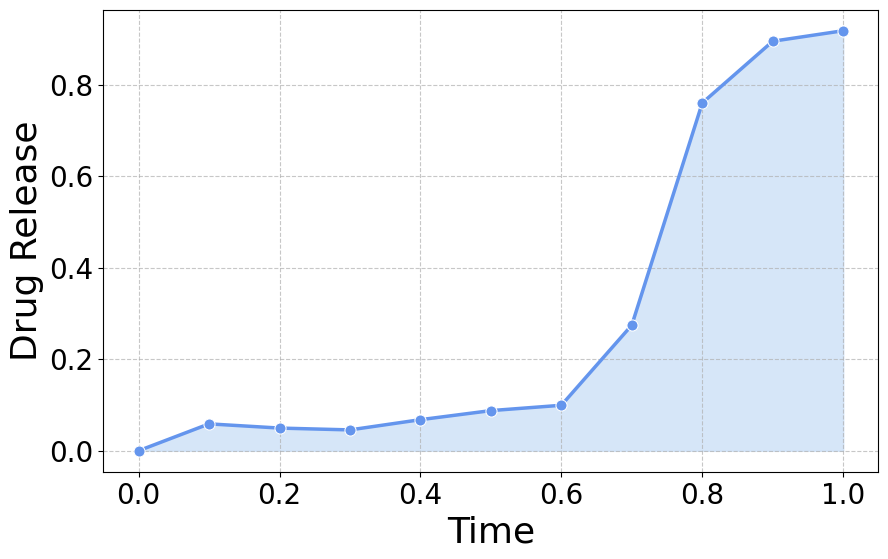

In [19]:
# Select formulation
fid = 1
g = interp_df[interp_df["Formulation Index"] == fid]

plt.figure(figsize=(10, 6))

# Cornflower blue
line_color = "#6495ED"   # line
fill_color = "#cce0f7"   # lighter fill

# Seaborn lineplot
sns.lineplot(
    x="Normalized Time", 
    y="Interpolated Release", 
    data=g, 
    marker="o", 
    color=line_color, 
    linewidth=2.5,
    markersize=8,
#    label=f"Formulation {fid}"
)

plt.fill_between(
    g["Normalized Time"],
    g["Interpolated Release"],
    color=fill_color,
    alpha=0.8
)

# Labels and title
plt.xlabel("Time", fontsize=26)
plt.ylabel("Drug Release", fontsize=26)

# Ticks
plt.tick_params(axis='both', which='major', labelsize=20)

# Optional grid
plt.grid(True, linestyle="--", alpha=0.7)


# Save and show
plt.savefig(f"formulation_{fid}_release_auc.png", dpi=300, bbox_inches='tight')
plt.show()


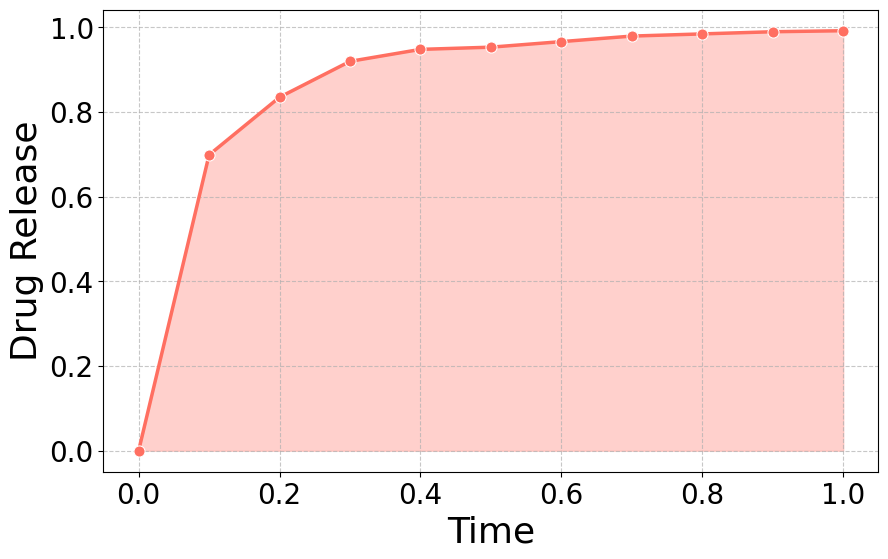

In [24]:
# Select formulation
fid = 2
g = interp_df[interp_df["Formulation Index"] == fid]

plt.figure(figsize=(10, 6))

# Angel Red
line_color = "#FF6F61"   # line
fill_color = "#FFB2AB"   # lighter fill

# Seaborn lineplot
sns.lineplot(
    x="Normalized Time", 
    y="Interpolated Release", 
    data=g, 
    marker="o", 
    color=line_color, 
    linewidth=2.5,
    markersize=8,
#    label=f"Formulation {fid}"
)

# Fill AUC area under curve
plt.fill_between(
    g["Normalized Time"],
    g["Interpolated Release"],
    color=fill_color,
    alpha=0.6
)

# Labels and title
plt.xlabel("Time", fontsize=26)
plt.ylabel("Drug Release", fontsize=26)

# Ticks
plt.tick_params(axis='both', which='major', labelsize=20)

# Optional grid
plt.grid(True, linestyle="--", alpha=0.7)


# Save and show
plt.savefig(f"formulation_{fid}_release_auc.png", dpi=300, bbox_inches='tight')
plt.show()


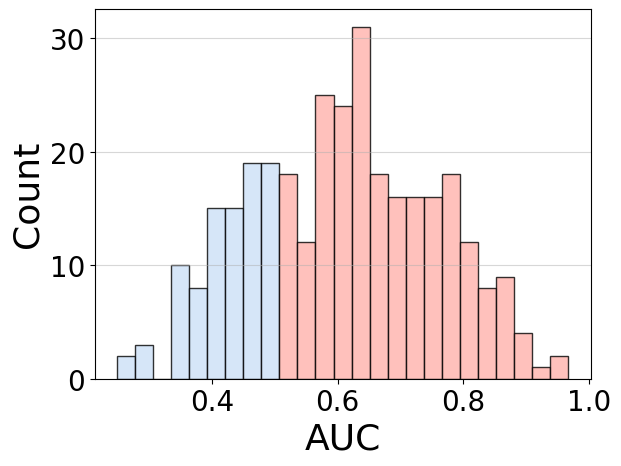

In [29]:
# Compute histogram data
counts, bins = np.histogram(auc["AUC"], bins=25)

# Define colors based on bin centers
bin_centers = 0.5 * (bins[1:] + bins[:-1])
colors = ["#cce0f7" if c <= 0.5 else "#FFB2AB" for c in bin_centers]

# Plot manually using plt.bar
plt.bar(bin_centers, counts, width=np.diff(bins), edgecolor="black", color=colors, align="center", alpha=0.8)

plt.xlabel("AUC", fontsize=26)
plt.ylabel("Count", fontsize=26)
plt.grid(axis="y", alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig("release_auc_distribution.png", dpi=300, bbox_inches='tight')
plt.show()